In [ ]:
import os
import json
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

X = train_df.drop(['ID', 'target'], axis=1)
y = train_df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss', n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1, n_jobs=-1),
    'SVM (Linear)': SVC(kernel='linear', random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'Naive Bayes': GaussianNB(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(),
    'Multi-Layer Perceptron': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

for i, model_name in enumerate(models.keys(), 1):
    print(f"{i:2d}. {model_name}")

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

cv_results = {}
cv_scores_detail = {}

for model_name, model in models.items():
    print(f"{model_name}...", end=" ")
    
    if model_name in ['SVM (Linear)', 'SVM (RBF)', 'K-Nearest Neighbors', 
                      'Multi-Layer Perceptron', 
                      'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis']:
        X_model = X_scaled
    else:
        X_model = X
    
    results = cross_validate(model, X_model, y, cv=cv, scoring='accuracy', n_jobs=-1, return_train_score=True)
    
    train_scores = results['train_score']
    test_scores = results['test_score']
    
    cv_results[model_name] = {
        'train_mean': train_scores.mean(),
        'train_std': train_scores.std(),
        'test_mean': test_scores.mean(),
        'test_std': test_scores.std(),
        'train_scores': train_scores,
        'test_scores': test_scores
    }
    
    print(f"{test_scores.mean():.4f} ± {test_scores.std():.4f}")

results_df = pd.DataFrame({
    'Algorithm': list(cv_results.keys()),
    'Mean Accuracy': [cv_results[name]['test_mean'] for name in cv_results.keys()],
    'Std Deviation': [cv_results[name]['test_std'] for name in cv_results.keys()]
})

results_df = results_df.sort_values('Mean Accuracy', ascending=False).reset_index(drop=True)
results_df['Rank'] = results_df.index + 1

print("\n결과 저장")
# 결과를 JSON 형식으로 저장
results_dict = {
    'cv_results': {
        model_name: {
            'train_mean': float(stats['train_mean']),
            'train_std': float(stats['train_std']),
            'test_mean': float(stats['test_mean']),
            'test_std': float(stats['test_std']),
            'train_scores': stats['train_scores'].tolist(),
            'test_scores': stats['test_scores'].tolist()
        } for model_name, stats in cv_results.items()
    },
    'rankings': results_df.to_dict('records')
}

# 결과 저장을 위한 디렉토리 생성
if not os.path.exists('results'):
    os.makedirs('results')

# JSON 파일로 저장
with open('results/cv_results.json', 'w', encoding='utf-8') as f:
    json.dump(results_dict, f, indent=4, ensure_ascii=False)

print("결과가 results/cv_results.json 파일에 저장되었습니다.")

# 교차검증 결과 시각화 및 통계 검정 (Wilcoxon 검정을 통한 모델 간 유의성 분석)

모델별 정확도 통계

[Test Accuracy]
Quadratic Discriminant Analysis    0.877714
Multi-Layer Perceptron             0.828901
XGBoost                            0.793985
LightGBM                           0.793893
Gradient Boosting                  0.781701
Random Forest                      0.767227
Extra Trees                        0.753976
Decision Tree                      0.707698
Naive Bayes                        0.658354
SVM (RBF)                          0.640147
SVM (Linear)                       0.608596
Logistic Regression                0.517838
K-Nearest Neighbors                0.489122
Linear Discriminant Analysis       0.483222
AdaBoost                           0.435746
dtype: float64

[Test Accuracy - Std]
Extra Trees                        0.001923
SVM (RBF)                          0.003422
Multi-Layer Perceptron             0.003507
Decision Tree                      0.004279
Random Forest                      0.004454
Quadratic Discriminant Analysis    0.004696
LightGBM  

/var/folders/10/l4f_yp1x1j50h0jqw1kpxpm80000gn/T/ipykernel_24811/548065691.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(
/var/folders/10/l4f_yp1x1j50h0jqw1kpxpm80000gn/T/ipykernel_24811/548065691.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/10/l4f_yp1x1j50h0jqw1kpxpm80000gn/T/ipykernel_24811/548065691.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')



그림 저장 완료: /Users/jeong-uchang/USW-Big-Data-Analysis/teamProject/results/test_accuracy_comparison_wilcoxon.png


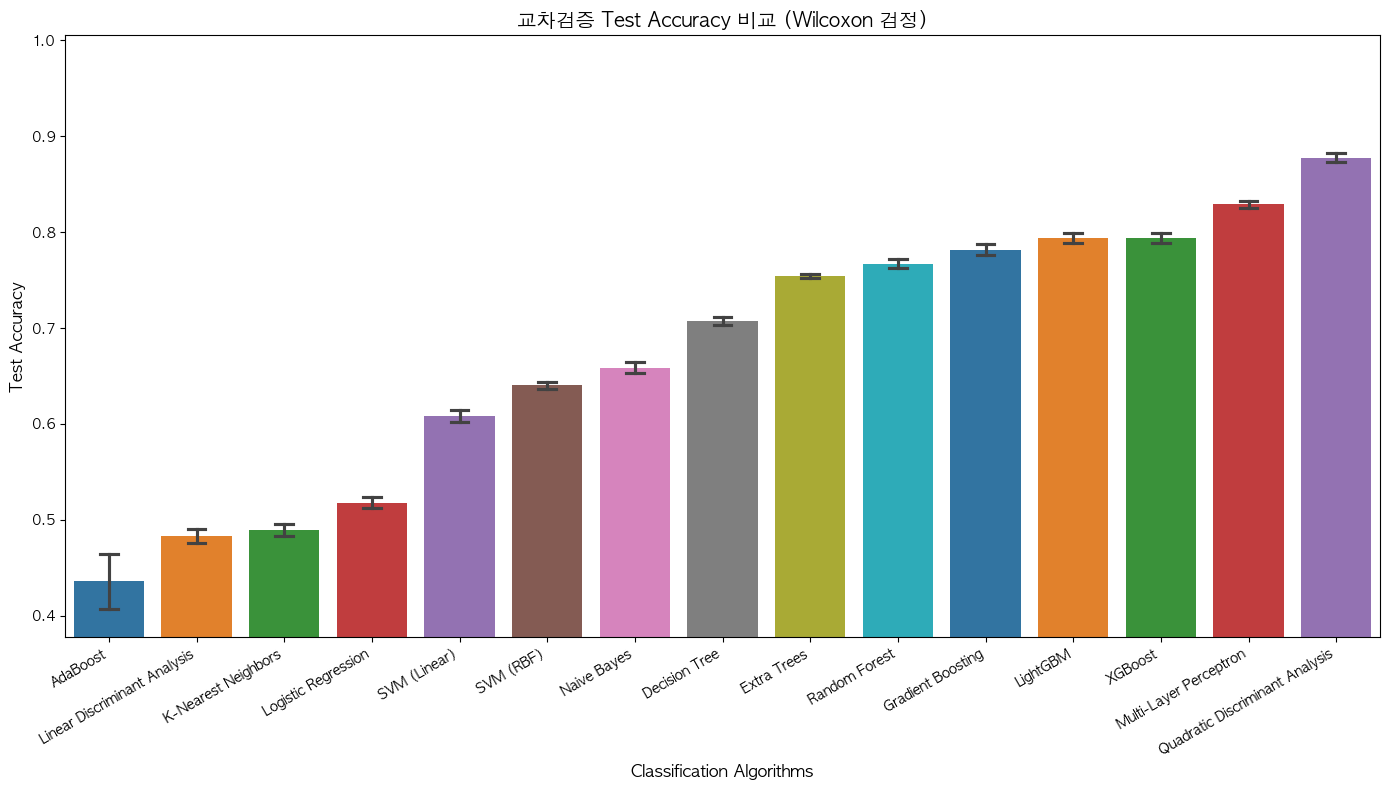

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04


Wilcoxon 검정 수행 중 오류 발생: module 'seaborn.categorical' has no attribute '_BoxPlotter'


/var/folders/10/l4f_yp1x1j50h0jqw1kpxpm80000gn/T/ipykernel_24811/548065691.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(
/var/folders/10/l4f_yp1x1j50h0jqw1kpxpm80000gn/T/ipykernel_24811/548065691.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/10/l4f_yp1x1j50h0jqw1kpxpm80000gn/T/ipykernel_24811/548065691.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')



그림 저장 완료: /Users/jeong-uchang/USW-Big-Data-Analysis/teamProject/results/train_accuracy_comparison.png


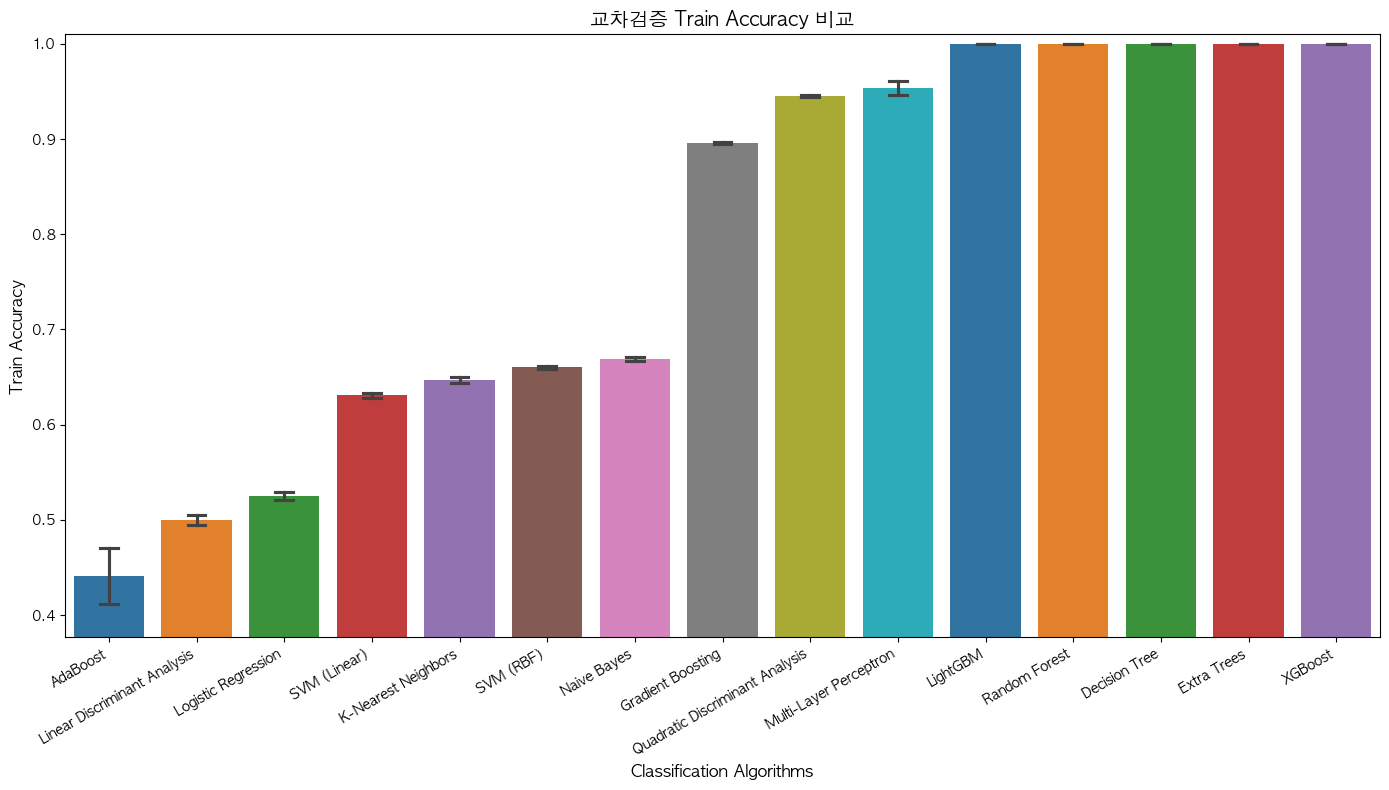


Train vs Test 비교 플롯 생성 중...
그림 저장 완료: /Users/jeong-uchang/USW-Big-Data-Analysis/teamProject/results/train_vs_test_accuracy_comparison.png


/var/folders/10/l4f_yp1x1j50h0jqw1kpxpm80000gn/T/ipykernel_24811/548065691.py:153: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/var/folders/10/l4f_yp1x1j50h0jqw1kpxpm80000gn/T/ipykernel_24811/548065691.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')


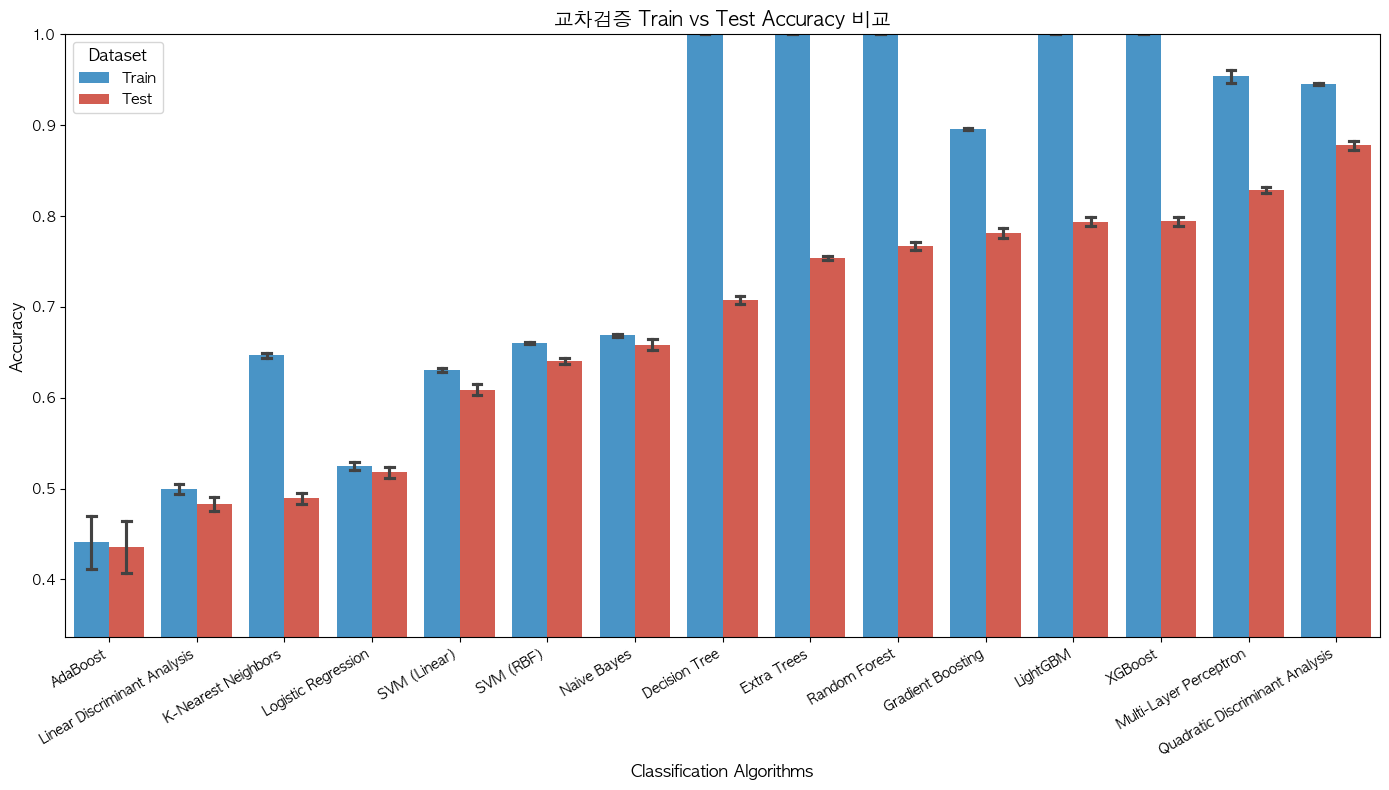


모든 분석 완료!


In [11]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # Mac의 경우
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 디렉토리 설정
BASE = os.path.dirname(os.path.abspath('/Users/jeong-uchang/USW-Big-Data-Analysis/teamProject/4조_교차검증_코드.ipynb'))
RESULTS_DIR = os.path.join(BASE, 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)

# JSON 파일 로드
with open(os.path.join(RESULTS_DIR, 'cv_results.json'), 'r') as f:
    cv_results = json.load(f)

# 각 모델의 test_scores를 dict로 변환
test_results = {}
train_results = {}

for model_name, results in cv_results['cv_results'].items():
    test_results[model_name] = results['test_scores']
    train_results[model_name] = results['train_scores']

# DataFrame 생성
df_test = pd.DataFrame(test_results)
df_train = pd.DataFrame(train_results)

# 통계 출력
print("="*60)
print("모델별 정확도 통계")
print("="*60)
print("\n[Test Accuracy]")
print(df_test.mean().sort_values(ascending=False))
print("\n[Test Accuracy - Std]")
print(df_test.std().sort_values())
print("\n[Train Accuracy]")
print(df_train.mean().sort_values(ascending=False))
print("="*60)

# 1. Test Accuracy 플롯 (Wilcoxon 검정 포함) - wine_plot_statannot.py 스타일
def plot_with_statannot(df: pd.DataFrame, title: str, filename: str, ylabel: str = 'Accuracy'):
    """wine_plot_statannot.py 스타일의 플롯 생성"""
    means = df.mean()
    order = list(means.sort_values().index)
    long = df.melt(var_name='method', value_name='accuracy')
    
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(
        x='method', 
        y='accuracy', 
        data=long, 
        capsize=.2, 
        order=order, 
        ci='sd', 
        palette='tab10'
    )
    
    # 참고 그림 스케일에 맞춰 상단 여백 확보
    min_val = long['accuracy'].min()
    max_val = long['accuracy'].max()
    ax.set(ylim=(min_val - 0.02, min(1.01, max_val + 0.12)))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    
    # 최고 성능 모델과 나머지 전부 비교
    if len(order) >= 2:
        box_pairs = [(m, order[-1]) for m in order if m != order[-1]]
        try:
            test_results = add_stat_annotation(
                ax, 
                data=long, 
                x='method', 
                y='accuracy', 
                order=order,
                box_pairs=box_pairs, 
                test='Wilcoxon', 
                text_format='star',
                comparisons_correction=None, 
                loc='inside', 
                verbose=2
            )
            print(f"\n[{title} - Wilcoxon 검정 결과]")
            print(test_results)
        except Exception as e:
            print(f"\nWilcoxon 검정 수행 중 오류 발생: {e}")
    
    plt.xlabel('Classification Algorithms', fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    out = os.path.join(RESULTS_DIR, filename)
    plt.savefig(out, dpi=300, bbox_inches='tight')
    print(f'\n그림 저장 완료: {out}')
    plt.show()

# Test Accuracy 플롯 (Wilcoxon 검정 포함)
plot_with_statannot(
    df_test, 
    '교차검증 Test Accuracy 비교 (Wilcoxon 검정)', 
    'test_accuracy_comparison_wilcoxon.png',
    'Test Accuracy'
)

# Train Accuracy 플롯
plot_with_statannot(
    df_train, 
    '교차검증 Train Accuracy 비교', 
    'train_accuracy_comparison.png',
    'Train Accuracy'
)

# 2. Train vs Test 비교 플롯
print("\n" + "="*60)
print("Train vs Test 비교 플롯 생성 중...")
print("="*60)

# 데이터 변환
data_list = []
for model_name in df_test.columns:
    for i in range(len(df_test)):
        data_list.append({
            'method': model_name,
            'fold': i + 1,
            'accuracy_train': df_train.loc[i, model_name],
            'accuracy_test': df_test.loc[i, model_name]
        })

df_results = pd.DataFrame(data_list)

# 모델별 평균 정확도 계산 (정렬용)
model_mean_test = df_results.groupby('method')['accuracy_test'].mean().sort_values()
sorted_models = model_mean_test.index.tolist()

fig, ax = plt.subplots(figsize=(14, 8))

df_melted = df_results.melt(
    id_vars=['method', 'fold'],
    value_vars=['accuracy_train', 'accuracy_test'],
    var_name='dataset',
    value_name='accuracy'
)
df_melted['dataset'] = df_melted['dataset'].map({
    'accuracy_train': 'Train',
    'accuracy_test': 'Test'
})

sns.barplot(
    data=df_melted,
    x='method',
    y='accuracy',
    hue='dataset',
    order=sorted_models,
    capsize=.2,
    ci='sd',
    palette={'Train': '#3498db', 'Test': '#e74c3c'}
)

min_acc = df_melted['accuracy'].min()
max_acc = df_melted['accuracy'].max()
y_range = max_acc - min_acc
ax.set(ylim=(max(0, min_acc - y_range * 0.1), min(1, max_acc + y_range * 0.2)))

ax.set_xlabel('Classification Algorithms', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('교차검증 Train vs Test Accuracy 비교', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.legend(title='Dataset', fontsize=11, title_fontsize=12)

plt.tight_layout()
out_path = os.path.join(RESULTS_DIR, 'train_vs_test_accuracy_comparison.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print(f'그림 저장 완료: {out_path}')
plt.show()

print("\n" + "="*60)
print("모든 분석 완료!")
print("="*60)
